In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import sys
sys.path.append("../../")

In [2]:
# Check Data 
datafile = pd.read_csv("artifacts/DNA-dataset:v0/dataset.csv.gz")
datafile.head()

,Unnamed: 0,chrom,seq,hepg2,k562,sknsh
0,0,chr7,CCTGGTCTTTCTTGCTAAATAAACATATCGTGCATCATCCAGATCT...,0.233601,0.060779,0.047194
1,1,chr1,CATAAAGATGAGGCTTGGCAAAGAACATCTCTCGGTGCCTCCCATT...,0.004565,0.379639,-0.244395
2,2,chr1,CATAAAGCCAATCACTGAGATGACAAGTACTGCCAGGAAAGAAGGC...,0.384537,0.036707,-0.004578
3,3,chr15,CATAAAGGCAGTGTAGACCCAAACAGTGAGCAGTAGCAAGATTTAT...,4.116494,4.508784,3.040183
4,4,chr12,CATAAAGGGCTGAACATGCTGTTGAAAAAATGTAGATATAAAAGTT...,1.423444,1.616602,1.335892


In [3]:
# Select data 
small_data = datafile.loc[ 
                (datafile['chrom'] =="chr1")
                # | (datafile['chrom'] =="chr2")
                # | (datafile['chrom'] =="chr3")
                # | (datafile['chrom'] =="chr4") 
                ]

In [4]:
from src.utils.sequence import seqs_to_one_hot

seq_x = [seqs_to_one_hot(seq)[:, 0, :] for seq in small_data['seq']]
small_data_x = np.array(seq_x)
print(small_data_x.shape) # Data Size 

(69457, 200, 4)


In [5]:
from grelu.lightning import LightningModel
import grelu.resources

DEVICE = "cuda:1"
model = LightningModel.load_from_checkpoint("artifacts/binary_atac_reward_model.ckpt")
model.eval()
model.to(DEVICE)


/data/yulai/anaconda3/envs/grelu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/yulai/anaconda3/envs/grelu/lib/python3.9/site-packages/enformer_pytorch/modeling_enformer.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch

LightningModel(
  (model): EnformerPretrainedModel(
    (embedding): EnformerTrunk(
      (conv_tower): EnformerConvTower(
        (blocks): ModuleList(
          (0): Sequential(
            (0): Conv1d(4, 768, kernel_size=(15,), stride=(1,), padding=same)
            (1): ConvBlock(
              (norm): Norm(
                (layer): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (conv): Conv1d(768, 768, kernel_size=(1,), stride=(1,), padding=same)
              (act): Activation(
                (layer): GELU()
              )
              (pool): Pool(
                (layer): AttentionPool(
                  (pool_fn): Rearrange('b d (n p) -> b d n p', p=2)
                  (to_attn_logits): Conv2d(768, 768, kernel_size=(1, 1), stride=(1, 1), bias=False)
                )
              )
              (dropout): Dropout(
                (layer): Identity()
              )
              (channel_transform): ChannelT

In [6]:
print(model.data_params['train_seq_len'])
model.data_params['tasks']

200


{'name': ['GM12878', 'HepG2', 'IMR90', 'Jurkat', 'K562', 'SKNSH', 'WTC11']}

In [7]:
import torch

data_loader = torch.utils.data.DataLoader(small_data_x.astype("float32"), batch_size = 128 , num_workers=0)
relabel_y = []

for batch in data_loader:
    batch = torch.permute(batch, (0, 2, 1)).to(DEVICE)
    relabel_y.append( model(batch).detach().cpu() ) 

In [8]:
relabel_y = np.concatenate(relabel_y)
relabel_y.shape

(69457, 7, 1)

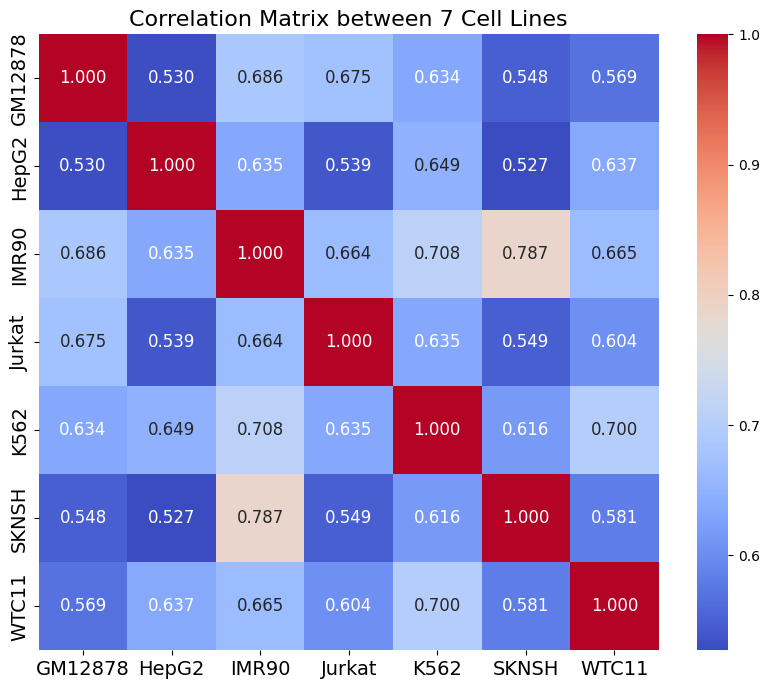

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cell line names
cell_lines = ['GM12878', 'HepG2', 'IMR90', 'Jurkat', 'K562', 'SKNSH', 'WTC11']

# Compute correlation matrix
correlation_matrix = np.corrcoef(relabel_y[:, :, 0], rowvar=False)

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm',
            xticklabels=cell_lines, yticklabels=cell_lines, 
            annot_kws={"size": 12})  # Setting annotation size to 12

# Set larger font size for axis labels and title
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Correlation Matrix between 7 Cell Lines', fontsize=16)

plt.show()


In [10]:
hepg2_relabel_y = relabel_y[:,1].reshape(-1)
sknsh_relabel_y = relabel_y[:,5].reshape(-1)

print(hepg2_relabel_y.shape)

(69457,)


In [11]:
# hepg2 quantiles: [0.0007521  0.00249002 0.00617734 0.01258835 0.02164795 0.03464964 0.05528896 0.09479034 0.19327941]
# sknsh quantiles: [0.0112936  0.02057241 0.03056607 0.04226346 0.05661238 0.0755002  0.10215383 0.1455929  0.24137686]

In [12]:
hepg2_quantiles = np.array([0.0007521,  0.00249002, 0.00617734, 0.01258835, 0.02164795, 0.03464964, 0.05528896, 0.09479034, 0.19327941], dtype=np.float32)
sknsh_quantiles = np.array([0.0112936,  0.02057241, 0.03056607, 0.04226346, 0.05661238, 0.0755002,  0.10215383, 0.1455929,  0.24137686], dtype=np.float32)

hepg2_relabel_y_list = hepg2_relabel_y.tolist()
sknsh_relabel_y_list = sknsh_relabel_y.tolist()


(69457,)
[4 5 5 7 0 0 8 7 8 8 1 1 1 2 2 0 0 8 8 9]


(array([5425.,    0.,    0.,    0.,    0., 5706.,    0.,    0.,    0.,
           0., 6206.,    0.,    0.,    0.,    0., 6588.,    0.,    0.,
           0.,    0., 7067.,    0.,    0.,    0.,    0.,    0., 7313.,
           0.,    0.,    0.,    0., 7590.,    0.,    0.,    0.,    0.,
        7630.,    0.,    0.,    0.,    0., 7916.,    0.,    0.,    0.,
           0., 8016.]),
 array([0.        , 0.19148936, 0.38297872, 0.57446809, 0.76595745,
        0.95744681, 1.14893617, 1.34042553, 1.53191489, 1.72340426,
        1.91489362, 2.10638298, 2.29787234, 2.4893617 , 2.68085106,
        2.87234043, 3.06382979, 3.25531915, 3.44680851, 3.63829787,
        3.82978723, 4.0212766 , 4.21276596, 4.40425532, 4.59574468,
        4.78723404, 4.9787234 , 5.17021277, 5.36170213, 5.55319149,
        5.74468085, 5.93617021, 6.12765957, 6.31914894, 6.5106383 ,
        6.70212766, 6.89361702, 7.08510638, 7.27659574, 7.46808511,
        7.65957447, 7.85106383, 8.04255319, 8.23404255, 8.42553191,
        8

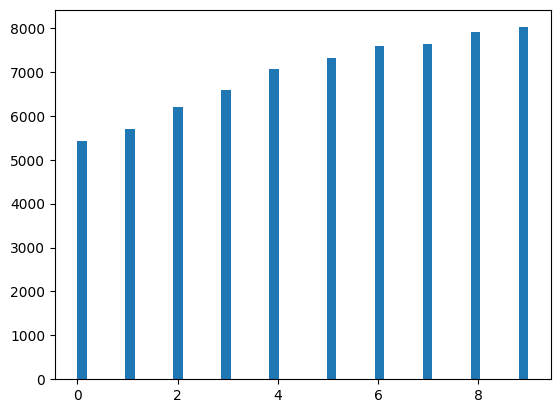

In [13]:
hepg2_discretized_indices = []
for idx, score in enumerate(hepg2_relabel_y_list):
    label = 0
    for q_idx, q_value in enumerate(hepg2_quantiles):
        if score < q_value:
            break
        label = q_idx + 1
    hepg2_discretized_indices.append(label)

hepg2_discretized_indices = np.array(hepg2_discretized_indices)
print(hepg2_discretized_indices.shape)
print(hepg2_discretized_indices[:20])
plt.hist(hepg2_discretized_indices, bins='auto')

(69457,)
[1 3 2 3 7 7 0 0 8 8 9 8 3 9 9 7 7 9 9 2]


(array([6862.,    0.,    0.,    0., 6941.,    0.,    0.,    0., 6972.,
           0.,    0.,    0., 7032.,    0.,    0.,    0., 6935.,    0.,
           0.,    0., 6902.,    0.,    0.,    0., 7008.,    0.,    0.,
           0., 7040.,    0.,    0.,    0., 6733.,    0.,    0.,    0.,
        7032.]),
 array([0.        , 0.24324324, 0.48648649, 0.72972973, 0.97297297,
        1.21621622, 1.45945946, 1.7027027 , 1.94594595, 2.18918919,
        2.43243243, 2.67567568, 2.91891892, 3.16216216, 3.40540541,
        3.64864865, 3.89189189, 4.13513514, 4.37837838, 4.62162162,
        4.86486486, 5.10810811, 5.35135135, 5.59459459, 5.83783784,
        6.08108108, 6.32432432, 6.56756757, 6.81081081, 7.05405405,
        7.2972973 , 7.54054054, 7.78378378, 8.02702703, 8.27027027,
        8.51351351, 8.75675676, 9.        ]),
 <BarContainer object of 37 artists>)

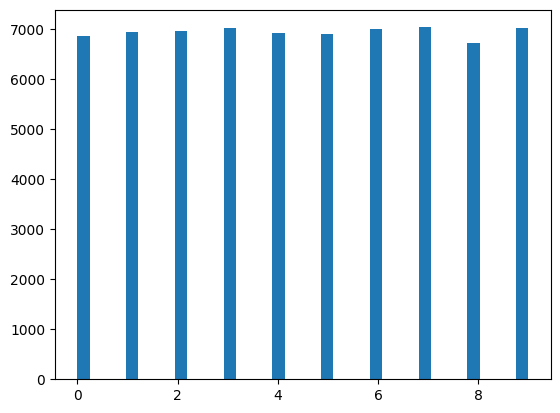

In [14]:
sknsh_discretized_indices = []
for idx, score in enumerate(sknsh_relabel_y_list):
    label = 0
    for q_idx, q_value in enumerate(sknsh_quantiles):
        if score < q_value:
            break
        label = q_idx + 1
    sknsh_discretized_indices.append(label)

sknsh_discretized_indices = np.array(sknsh_discretized_indices)
print(sknsh_discretized_indices.shape)
print(sknsh_discretized_indices[:20])
plt.hist(sknsh_discretized_indices, bins='auto')

In [15]:
np.savez_compressed("./artifacts/DNA-dataset:v0/y_HepG2_10class_atac_clsfree.npz", x = small_data_x, y = hepg2_discretized_indices)
np.savez_compressed("./artifacts/DNA-dataset:v0/y_SKNSH_10class_atac_clsfree.npz", x = small_data_x, y = sknsh_discretized_indices)

: 